In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
import os
import glob

In [3]:
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from pymono.config import mono_dark_6x6, mono_light_3x3, mono_light_6x6, mono_light_all_6x6

In [6]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import mean_rms, weighted_mean_and_sigma

In [7]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies
from pymono.plt_funcs import  plot_true_predicted, plotxyz

In [8]:
from pymono.cnn_func import MonoDataset, split_data, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [9]:
from pymono.cnn_func import test_loggin

In [10]:
test_loggin()

# Pymono

- Studies the use of a ConNN to reconstruct the positions (x,y,z) of impinging gammas in a monolithic crystal

## Setup

### dark 6 x 6

In [11]:
imgs6, mdata6 = select_image_and_metadata(mono_dark_6x6, 9)

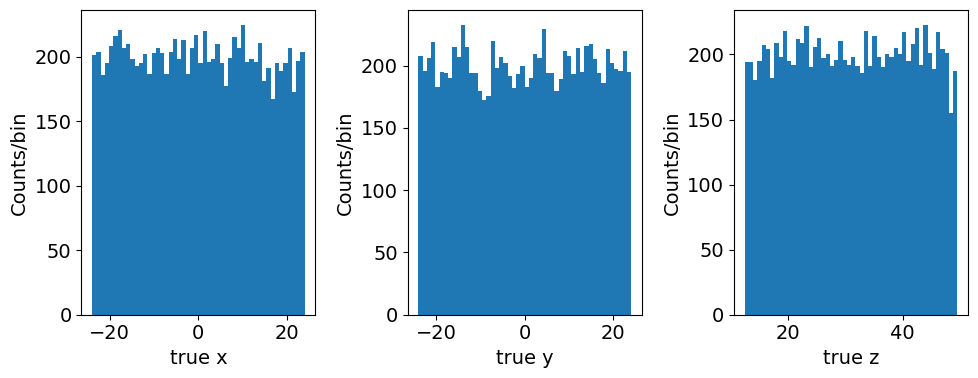

In [12]:
plot_true_positions(mdata6)

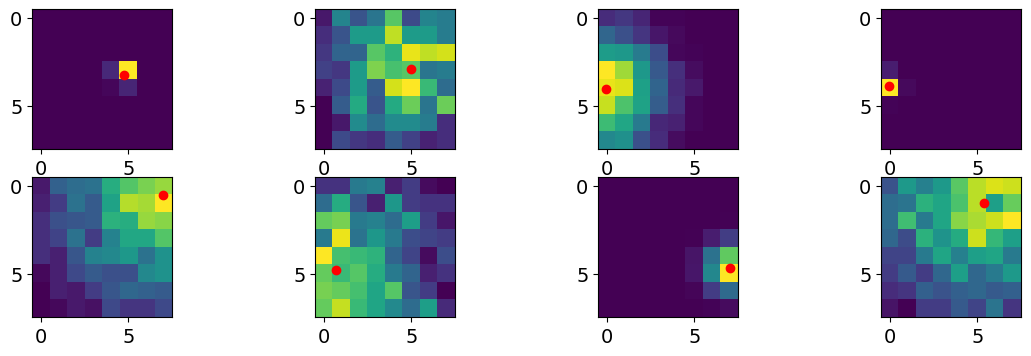

In [13]:
plot_images(imgs6, mdata6, range(0,8))

### Light 6 x 6

In [14]:
imgsl6, mdatal6 = select_image_and_metadata(mono_light_6x6, 9)

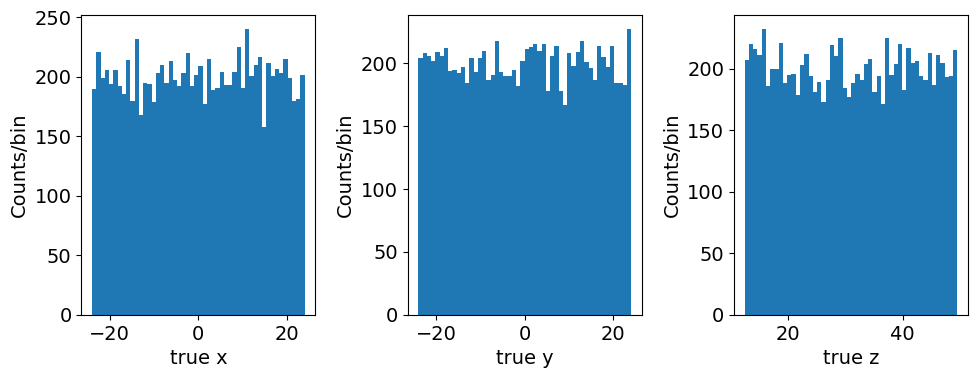

In [15]:
plot_true_positions(mdatal6)

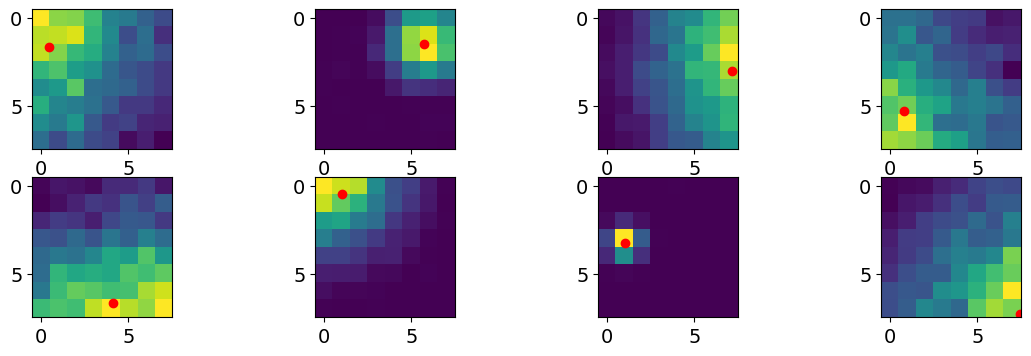

In [19]:
plot_images(imgsl6, mdatal6, range(0,8))

### Light 3 x 3

In [20]:
imgsl3, mdatal3 = select_image_and_metadata(mono_light_3x3, 9)

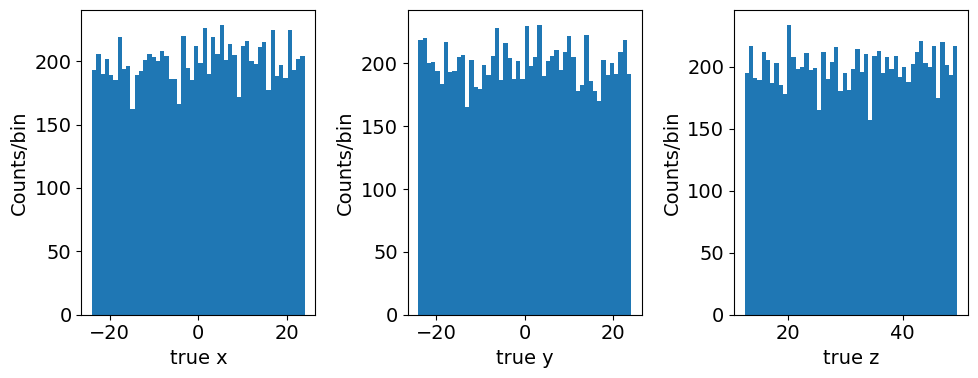

In [21]:
plot_true_positions(mdatal3)

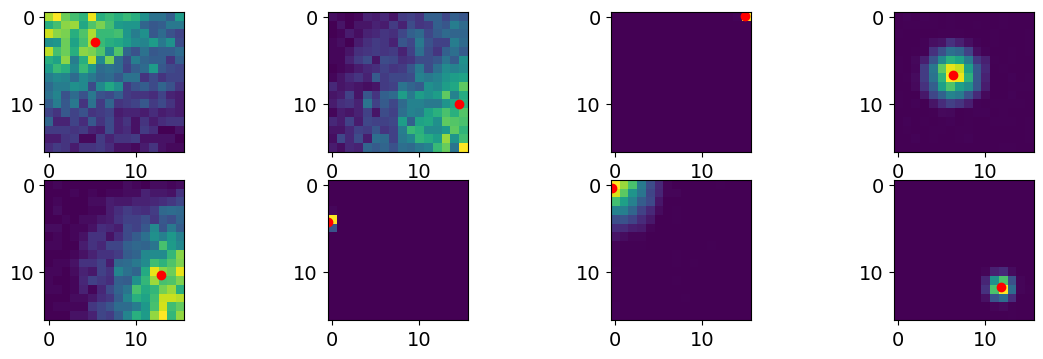

In [22]:
plot_images(imgsl3, mdatal3, range(0,8), pixel_size = 3, grid_size=16)

### Light All 6x6

In [23]:
imgsla6, mdatala6 = select_image_and_metadata(mono_light_all_6x6, 9)

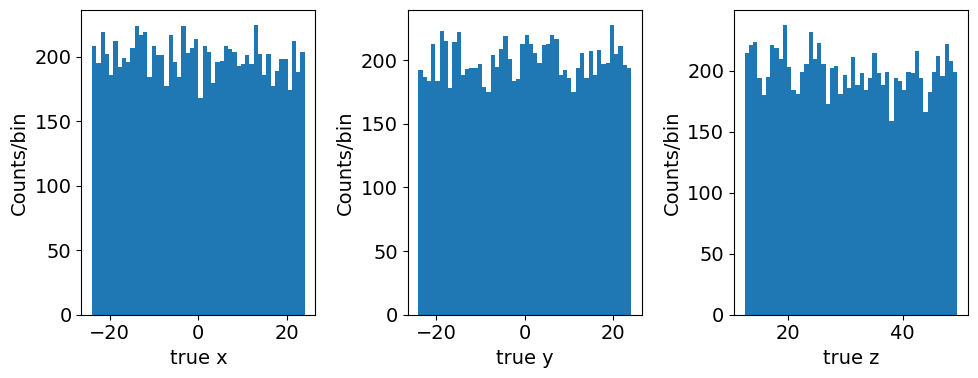

In [24]:
plot_true_positions(mdatala6)

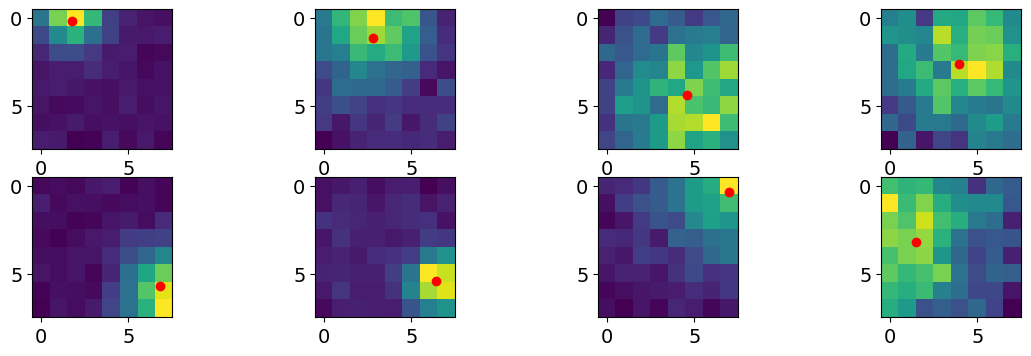

In [25]:
plot_images(imgsla6, mdatala6, range(0,8))

In [26]:
ene_light6x6 = energy(mono_light_6x6, 9)
ene_light_all_6x6 = energy(mono_light_all_6x6, 9)
ene_light3x3 = energy(mono_light_3x3, 9)
ene_dark6x6 = energy(mono_dark_6x6, 9)

In [27]:
mean6x6, std6x6, fwhm6x6 = mean_rms(ene_light6x6)
mean6x6a, std6x6a, fwhm6x6a = mean_rms(ene_light_all_6x6)
mean3x3, std3x3, fwhm3x3 = mean_rms(ene_light3x3)
mean6x6d, std6x6d, fwhm6x6d = mean_rms(ene_dark6x6)

print(f"resolution (FWHM): light 6x6     = {fwhm6x6:.2f}, light 3x3 = {fwhm3x3:.2f} ")
print(f"resolution (FWHM): light 6x6 all = {fwhm6x6a:.2f}, dark = {fwhm6x6d:.2f} ")

resolution (FWHM): light 6x6     = 0.05, light 3x3 = 0.04 
resolution (FWHM): light 6x6 all = 0.03, dark = 0.84 


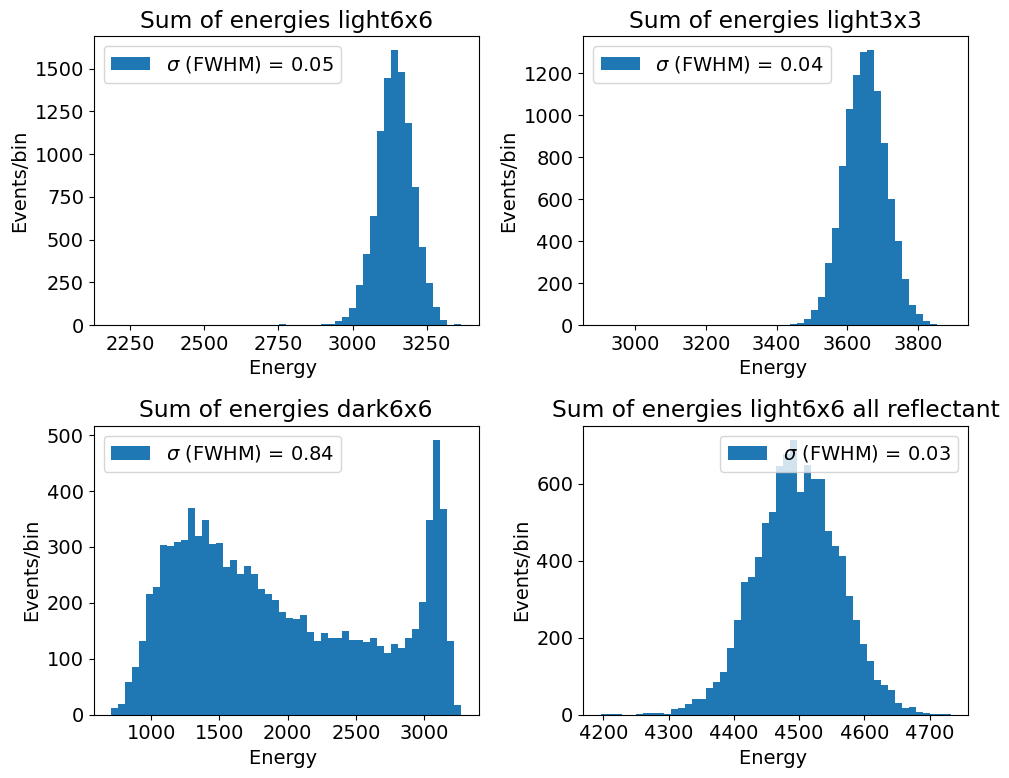

In [28]:
plot_energies(ene_light6x6, ene_light_all_6x6, ene_light3x3, ene_dark6x6)

In [191]:
first_file = 0  # initial file
last_file  = 20  # lasta file
batch_size = 1000  # Batch size
dataset = MonoDataset(mono_light_3x3, first_file, last_file)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
ntot_evts = len(dataset)
print(f"Loaded {len(dataset)} events")
# Split the data into training, validation, and test sets
trsz = split_data(dataset, train_fraction=0.7, val_fraction=0.2)
print(f" train size = {trsz.train_size}")
print(f" val size = {trsz.val_size}")
print(f" test size = {trsz.test_size}")
print(f" train indices = {trsz.train_indices}")
print(f" val indices = {trsz.val_indices}")
print(f" test indices = {trsz.test_indices}")

Loaded 200000 events
 train size = 140000
 val size = 40000
 test size = 20000
 train indices = range(0, 140000)
 val indices = range(140000, 180000)
 test indices = range(180000, 200000)


## Data set

In [192]:
# Define subsets of the dataset
train_dataset = torch.utils.data.Subset(dataset, trsz.train_indices)
print(f"{len(train_dataset)} training events ({100*len(train_dataset)/ntot_evts}%)")
val_dataset = torch.utils.data.Subset(dataset, trsz.val_indices)
print(f"{len(val_dataset)} validation events ({100*len(val_dataset)/ntot_evts}%)")
test_dataset = torch.utils.data.Subset(dataset, trsz.test_indices)
print(f"{len(test_dataset)} test events ({100*len(test_dataset)/ntot_evts}%)")

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

140000 training events (70.0%)
40000 validation events (20.0%)
20000 test events (10.0%)


In [193]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 16, 16])
torch.Size([1000, 3])
tensor([[0.5250, 0.5500, 0.7500, 0.5750, 0.5750, 0.5500, 0.6250, 0.5750, 1.0000,
         0.5500, 0.7750, 0.7500, 0.7500, 0.8250, 0.6250, 0.8750],
        [0.3750, 0.5000, 0.6500, 0.3500, 0.5250, 0.4500, 0.8000, 0.5500, 0.5250,
         0.4750, 0.6000, 0.5250, 0.6000, 0.5750, 0.6750, 0.6500],
        [0.3750, 0.2750, 0.4000, 0.6000, 0.3500, 0.6750, 0.6750, 0.6750, 0.8750,
         0.8500, 0.7000, 0.8000, 0.5000, 0.6250, 0.7000, 0.5250],
        [0.2500, 0.4750, 0.5750, 0.4750, 0.5000, 0.6750, 0.4000, 0.5750, 0.6000,
         0.5250, 0.5750, 0.6000, 0.6500, 0.7000, 0.7250, 0.6250],
        [0.3250, 0.5500, 0.6250, 0.2750, 0.4750, 0.4500, 0.3750, 0.3750, 0.3000,
         0.3500, 0.3750, 0.6500, 0.7750, 0.4750, 0.4750, 0.5500],
        [0.5000, 0.4500, 0.3000, 0.4500, 0.3500, 0.5250, 0.6250, 0.5000, 0.4500,
         0.5250, 0.5250, 0.5250, 0.6250, 0.4500, 0.5000, 0.8000],
        [0.3250, 0.4250, 0.2750, 0.3500, 0.3500, 0.3250, 0.4750, 0

In [194]:
img = images[0,0,:,:]
img

tensor([[0.5250, 0.5500, 0.7500, 0.5750, 0.5750, 0.5500, 0.6250, 0.5750, 1.0000,
         0.5500, 0.7750, 0.7500, 0.7500, 0.8250, 0.6250, 0.8750],
        [0.3750, 0.5000, 0.6500, 0.3500, 0.5250, 0.4500, 0.8000, 0.5500, 0.5250,
         0.4750, 0.6000, 0.5250, 0.6000, 0.5750, 0.6750, 0.6500],
        [0.3750, 0.2750, 0.4000, 0.6000, 0.3500, 0.6750, 0.6750, 0.6750, 0.8750,
         0.8500, 0.7000, 0.8000, 0.5000, 0.6250, 0.7000, 0.5250],
        [0.2500, 0.4750, 0.5750, 0.4750, 0.5000, 0.6750, 0.4000, 0.5750, 0.6000,
         0.5250, 0.5750, 0.6000, 0.6500, 0.7000, 0.7250, 0.6250],
        [0.3250, 0.5500, 0.6250, 0.2750, 0.4750, 0.4500, 0.3750, 0.3750, 0.3000,
         0.3500, 0.3750, 0.6500, 0.7750, 0.4750, 0.4750, 0.5500],
        [0.5000, 0.4500, 0.3000, 0.4500, 0.3500, 0.5250, 0.6250, 0.5000, 0.4500,
         0.5250, 0.5250, 0.5250, 0.6250, 0.4500, 0.5000, 0.8000],
        [0.3250, 0.4250, 0.2750, 0.3500, 0.3500, 0.3250, 0.4750, 0.3500, 0.3750,
         0.3750, 0.4250, 0.5500, 0.40

### Train the network with CNN_basic 

In [65]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [195]:
# Load the model.
model = CNN_3x3(dropout=False).to(device)
print(model)

CNN_basic(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [196]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [197]:
epochs = 10

In [198]:

train_losses, val_losses =train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, epochs=epochs)

Running for epochs ->10
input data shape =>torch.Size([1000, 1, 16, 16])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 8, 8])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 4, 4])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 2, 2])
(1,1,512) => (1,1,3) =>torch.Size([1000, 2048])


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (1000x2048 and 512x3)

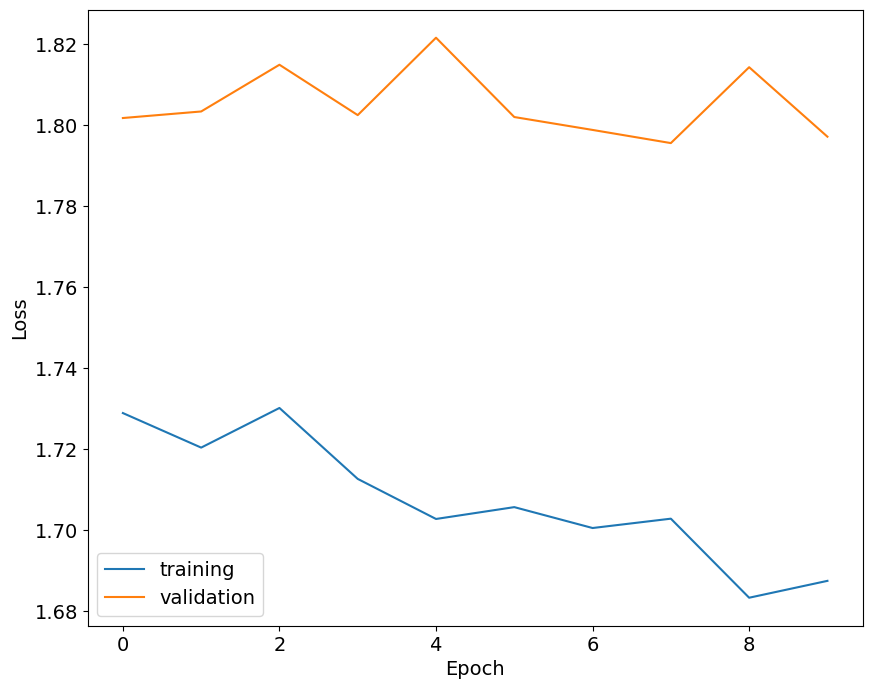

In [187]:
# Plot training and validation loss
xvals_train = np.arange(0,epochs,1)
xvals_val = np.arange(0,epochs,1)
plt.plot(xvals_train,train_losses,label='training')
plt.plot(xvals_val,val_losses,label='validation')
plt.xlabel("Epoch",fontsize=14)
plt.ylabel("Loss")
plt.legend()

In [188]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6)

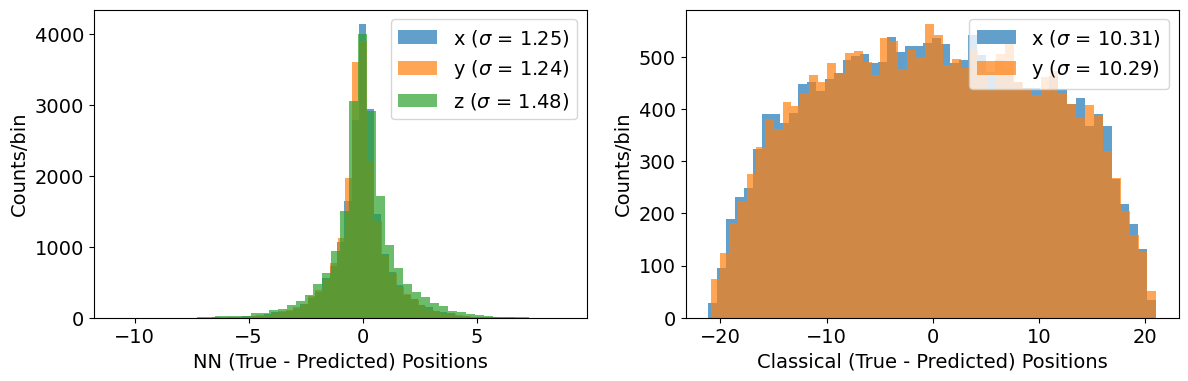

In [189]:
plot_true_predicted(tdeltas, nbins = 50)

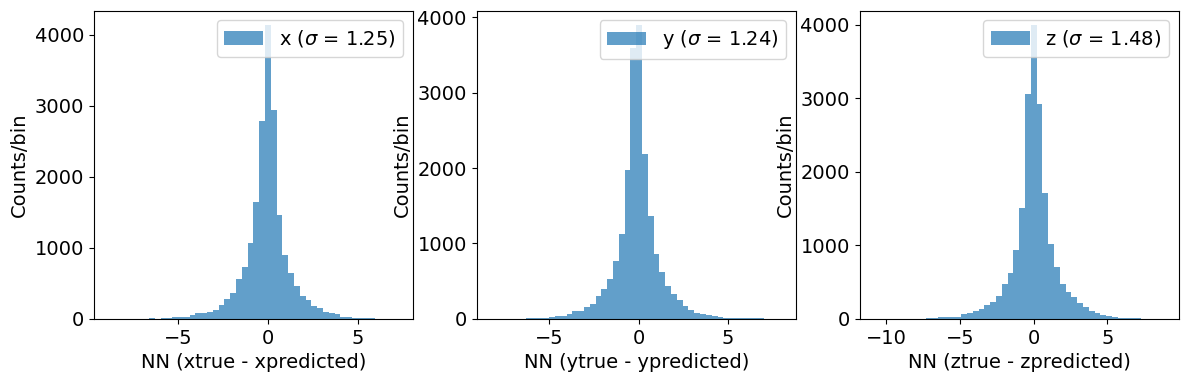

In [190]:
plotxyz(tdeltas, nbins=50)